# Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statistics import mode
from pyspark.sql import functions as f
from pyspark.sql import types as t
from pyspark.sql import Window as w
from pyspark.sql import SparkSession
from pyspark import StorageLevel
from pyspark.sql.functions import col,isnan, when, count
from pyspark.sql.functions import *
from pyspark.sql.types import DecimalType
from pyspark.ml.feature import Bucketizer, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from colorama import Fore
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

# Setup

In [2]:
# Obtém o diretório atual (onde o notebook está localizado)
current_directory = os.getcwd()

# Volta uma pasta (vai para o diretório pai)
parent_directory = os.path.dirname(current_directory)

# Cria uma pasta chamada 'datasets' no diretório pai
datasets_directory = os.path.join(parent_directory, 'datasets')

# Verifica se a pasta 'datasets' já existe, se não, a cria
if not os.path.exists(datasets_directory):
    os.makedirs(datasets_directory)
    

df = pd.read_csv(f"{parent_directory}\\Customer-Churn - Customer-Churn.csv")

categorical_columns = ['gender', 'Contract', 'PaymentMethod']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

csv_file_path = os.path.join(datasets_directory, 'full_data.csv') 

df_encoded.to_csv(csv_file_path , index=False)

spark = SparkSession.builder \
    .appName("Ler Google Sheets com Spark") \
    .getOrCreate()

#NAME = f'dataset_A3Data'
# Initialise spark
spark = SparkSession.builder.appName("test_pyspark").getOrCreate()

INPUT_PATH = csv_file_path
# Path output
PATH_OUTPUT = datasets_directory
# Name file output
FILE_NAME_OUTPUT = 'dataset_A3Data'
#Time
TSTAMP = datetime.now()

# Reading dataset

In [3]:
try:
    del df_spark
except:
    pass

df_spark = spark.read.option("delimiter", ",").csv(INPUT_PATH, header=True, inferSchema=True)

In [4]:
rows = df_spark.count()
cols = len(df_spark.columns)
print(f'Dimension of the Dataframe is: {(rows,cols)}')

Dimension of the Dataframe is: (7043, 24)


# Check nulls

In [5]:
allCols = df_spark.columns
df_spark.select(*[
    (
        f.count(f.when(f.col(c).isNull(), c)) if t not in ("timestamp", "date")
        else f.count(f.when(f.col(c).isNull(), c))
    ).alias(c)
    for c, t in df_spark.dtypes if c in allCols
]).show(truncate=6)


+----------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+----------------+--------------+------------+-----+-----------+-----------------+-----------------+-------------------------------------+------------------------------+--------------------------+
|customerID|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|PaperlessBilling|MonthlyCharges|TotalCharges|Churn|gender_Male|Contract_One year|Contract_Two year|PaymentMethod_Credit card (automatic)|PaymentMethod_Electronic check|PaymentMethod_Mailed check|
+----------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+----------------+--------------+------------+-----+-----------+-----

# Checking column by column

In [6]:
df_spark.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- MonthlyCharges: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)
 |-- gender_Male: boolean (nullable = true)
 |-- Contract_One year: boolean (nullable = true)
 |-- Contract_Two year: boolean (nullable = true)
 |-- PaymentMethod_Credit card (automatic): boolean (nullable

# Drop columns

In [7]:
cols_drop_1st = ('customerID')

df_spark = df_spark.drop(cols_drop_1st)

# Check and remove nulls

In [8]:
df_spark.printSchema()

root
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- MonthlyCharges: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)
 |-- gender_Male: boolean (nullable = true)
 |-- Contract_One year: boolean (nullable = true)
 |-- Contract_Two year: boolean (nullable = true)
 |-- PaymentMethod_Credit card (automatic): boolean (nullable = true)
 |-- PaymentMethod_Electronic che

# Organize columns

In [9]:
df_pd_charges = df_spark.select('TotalCharges').toPandas()
df_pd_charges.head()

,TotalCharges
0,"8672,45"
1,"8477,6"
2,"7990,05"
3,"7365,7"
4,"7804,15"


In [10]:
df_spark = df_spark.withColumn("MonthlyCharges", regexp_replace(col("MonthlyCharges"), ",", "."))
df_spark = df_spark.withColumn("MonthlyCharges", col("MonthlyCharges").cast("double"))
df_spark = df_spark.withColumn("TotalCharges", regexp_replace(col("TotalCharges"), ",", "."))
df_spark = df_spark.withColumn("TotalCharges", col("TotalCharges").cast("double"))

In [11]:
df_spark = df_spark.withColumn("Partner", when(col("Partner") == "Yes", True).otherwise(False))
df_spark = df_spark.withColumn("Dependents", when(col("Dependents") == "Yes", True).otherwise(False))
df_spark = df_spark.withColumn("InternetService", when(col("InternetService") == "DSL", False).otherwise(True))
df_spark = df_spark.withColumn("PhoneService", when(col("PhoneService") == "Yes", True).otherwise(False))
df_spark = df_spark.withColumn("MultipleLines", when(col("MultipleLines") == "Yes", True).otherwise(False))
df_spark = df_spark.withColumn("OnlineSecurity", when(col("OnlineSecurity") == "Yes", True).otherwise(False))
df_spark = df_spark.withColumn("OnlineBackup", when(col("OnlineBackup") == "Yes", True).otherwise(False))
df_spark = df_spark.withColumn("DeviceProtection", when(col("DeviceProtection") == "Yes", True).otherwise(False))
df_spark = df_spark.withColumn("TechSupport", when(col("TechSupport") == "Yes", True).otherwise(False))
df_spark = df_spark.withColumn("StreamingTV", when(col("StreamingTV") == "Yes", True).otherwise(False))
df_spark = df_spark.withColumn("StreamingMovies", when(col("StreamingMovies") == "Yes", True).otherwise(False))
df_spark = df_spark.withColumn("PaperlessBilling", when(col("PaperlessBilling") == "Yes", True).otherwise(False))

In [12]:
df_spark = df_spark.withColumn("SeniorCitizen", when(col("SeniorCitizen") == 0, False).otherwise(True))

In [13]:
df_spark = df_spark.withColumnRenamed("InternetService", "InternetServiceFiber")

In [14]:
df_pd = df_spark.toPandas()
df_pd

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetServiceFiber,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Male,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,False,True,True,72,True,True,True,True,True,True,...,True,118.75,8672.45,No,False,False,True,False,False,False
1,False,False,False,71,True,True,True,True,True,True,...,True,118.65,8477.60,No,False,False,True,False,True,False
2,False,True,False,68,True,True,True,True,True,True,...,False,118.60,7990.05,No,False,False,True,False,False,True
3,False,False,False,61,True,True,True,True,True,True,...,True,118.60,7365.70,No,False,True,False,False,True,False
4,False,False,False,67,True,True,True,True,True,True,...,True,118.35,7804.15,Yes,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,False,False,False,53,True,False,True,False,False,False,...,False,18.70,1005.70,No,False,False,True,False,False,True
7039,False,True,True,25,True,False,True,False,False,False,...,True,18.70,383.65,No,False,False,True,False,False,True
7040,False,False,False,36,True,False,True,False,False,False,...,True,18.55,689.00,No,True,False,True,True,False,False
7041,False,True,False,59,True,False,True,False,False,False,...,False,18.40,1057.85,No,False,False,True,False,False,False


# Creating target

In [15]:
df_spark = df_spark.withColumn("Churn", when(col("Churn") == "Yes", True).otherwise(False))

# Quartis and some analysis

In [16]:
quartis = [0.0, 0.25, 0.5, 0.75, 1.0]
result = df_spark.approxQuantile("tenure", quartis, 0.01)

for i, quartil in enumerate(quartis):
    print(f"Quartil {quartil}: {result[i]}")

Quartil 0.0: 0.0
Quartil 0.25: 9.0
Quartil 0.5: 29.0
Quartil 0.75: 55.0
Quartil 1.0: 72.0


In [17]:
quartis = [0.0, 0.25, 0.5, 0.75, 1.0]
result = df_spark.approxQuantile("MonthlyCharges", quartis, 0.01)

for i, quartil in enumerate(quartis):
    print(f"Quartil {quartil}: {result[i]}")

Quartil 0.0: 18.25
Quartil 0.25: 36.25
Quartil 0.5: 70.25
Quartil 0.75: 89.55
Quartil 1.0: 118.75


In [18]:
quartis = [0.0, 0.25, 0.5, 0.75, 1.0]
result = df_spark.approxQuantile("TotalCharges", quartis, 0.01)

for i, quartil in enumerate(quartis):
    print(f"Quartil {quartil}: {result[i]}")

Quartil 0.0: 18.8
Quartil 0.25: 402.5
Quartil 0.5: 1379.6
Quartil 0.75: 3682.45
Quartil 1.0: 8684.8


# Create categories

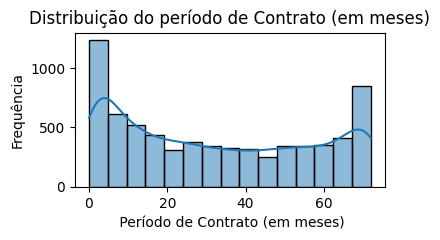

In [19]:
df_pd_tenure = df_spark.select('tenure').toPandas()
fig, ax = plt.subplots(figsize=(4, 2))
sns.histplot(data=df_pd_tenure, x='tenure', bins=15, kde=True)
plt.xlabel(' Período de Contrato (em meses)')
plt.ylabel('Frequência')
plt.title('Distribuição do período de Contrato (em meses)')
plt.show()

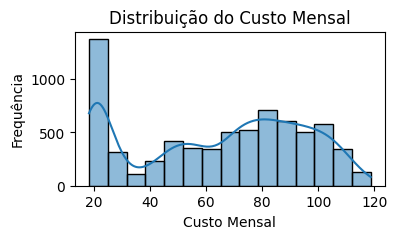

In [20]:
df_pd_MonthlyCharges = df_spark.select('MonthlyCharges').toPandas()
fig, ax = plt.subplots(figsize=(4, 2))
sns.histplot(data=df_pd_MonthlyCharges, x='MonthlyCharges', bins=15, kde=True)
plt.xlabel('Custo Mensal')
plt.ylabel('Frequência')
plt.title('Distribuição do Custo Mensal')
plt.show()

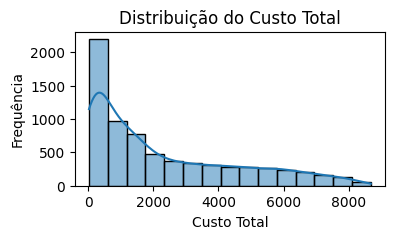

In [21]:
df_pd_TotalCharges = df_spark.select('TotalCharges').toPandas()
fig, ax = plt.subplots(figsize=(4, 2))
sns.histplot(data=df_pd_TotalCharges, x='TotalCharges', bins=15, kde=True)
plt.xlabel('Custo Total')
plt.ylabel('Frequência')
plt.title('Distribuição do Custo Total')
plt.show()

# Rename categories

In [22]:
df_spark.printSchema()

root
 |-- SeniorCitizen: boolean (nullable = false)
 |-- Partner: boolean (nullable = false)
 |-- Dependents: boolean (nullable = false)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: boolean (nullable = false)
 |-- MultipleLines: boolean (nullable = false)
 |-- InternetServiceFiber: boolean (nullable = false)
 |-- OnlineSecurity: boolean (nullable = false)
 |-- OnlineBackup: boolean (nullable = false)
 |-- DeviceProtection: boolean (nullable = false)
 |-- TechSupport: boolean (nullable = false)
 |-- StreamingTV: boolean (nullable = false)
 |-- StreamingMovies: boolean (nullable = false)
 |-- PaperlessBilling: boolean (nullable = false)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: boolean (nullable = false)
 |-- gender_Male: boolean (nullable = true)
 |-- Contract_One year: boolean (nullable = true)
 |-- Contract_Two year: boolean (nullable = true)
 |-- PaymentMethod_Credit card (automatic): boolean (nullable = true)
 

# Checking target

In [23]:
df_spark.groupBy('Churn').count().orderBy('Churn').show()

+-----+-----+
|Churn|count|
+-----+-----+
|false| 5174|
| true| 1869|
+-----+-----+



# Saving full dataset

In [26]:
# Spark df_spark to Pandas df_pd
df_pd = df_spark.toPandas()

# Store result
df_pd.to_csv(PATH_OUTPUT + f"\\{FILE_NAME_OUTPUT}.csv", index=False, mode='w')
print(Fore.YELLOW + f'Result generate with sucess at {TSTAMP}')
print(Fore.BLUE + f'Directory: {PATH_OUTPUT}')

Result generate with sucess at 2023-10-06 12:35:34.339821
Directory: C:\Users\victo\Desktop\technical_test\datasets


# Save Train and Validation datasets

In [25]:
df_pd_train = df_pd.sample(frac=0.80, random_state=42)
df_pd_validation = df_pd[~df_pd.index.isin(df_pd_train.index)]

df_pd_train.to_csv(PATH_OUTPUT + f"\\{FILE_NAME_OUTPUT}_train.csv", index=False, mode='w')
df_pd_validation.to_csv(PATH_OUTPUT + f"\\{FILE_NAME_OUTPUT}_validation.csv", index=False, mode='w')
print(Fore.YELLOW + f'Result generate with sucess at {TSTAMP}')
print(Fore.BLUE + f'Directory: {PATH_OUTPUT}')

Result generate with sucess at 2023-10-06 12:35:34.339821
Directory: C:\Users\victo\Desktop\technical_test\datasets
